In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller

In [ ]:
# elec_data1 = pd.read_csv("Electric_Production.csv", index_col="DATE", date_format="%d/%m/%Y")

In [ ]:
# elec_data1

# 데이터 로드 및 파악

In [2]:
elec_data2 = pd.read_csv("electricity_complete_dataset.csv")

In [3]:
elec_data2.tail(10)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
2096,2020-09-27,101703.490,57.920029,101703.490,57.920029,0.000,0.000000,0.000000,8.8,13.4,20.9,3.0,N,N
2097,2020-09-28,114651.140,59.746053,114651.140,59.746053,0.000,0.000000,0.000000,6.5,13.6,18.3,0.0,N,N
2098,2020-09-29,112076.460,42.120178,108164.360,43.859150,3912.100,-5.960098,0.041667,4.3,21.0,18.4,0.0,N,N
2099,2020-09-30,113620.210,38.057641,111746.460,38.823390,1873.750,-7.610000,0.020833,10.7,19.4,13.0,0.6,N,N
2100,2020-10-01,106641.790,34.654671,95349.610,41.651658,11292.180,-24.426925,0.125000,9.4,19.5,21.2,1.8,N,N
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N
2105,2020-10-06,122607.560,75.771059,122607.560,75.771059,0.000,0.000000,0.000000,8.9,12.6,5.8,1.0,N,N


In [ ]:
#### 데이터 설명 (kaggle에서 찾은 데이터 설명 참고)
# date : datetime, the date of the recording
# demand : float, a total daily electricity demand in MWh
# RRP : float, a recommended retail price in AUD$ / MWh
# demand_pos_RRP : float, a total daily demand at positive RRP in MWh
# RRP_positive : float, an averaged positive RRP, weighted by the corresponding intraday demand in AUD$ / MWh
# demand_neg_RRP : float, an total daily demand at negative RRP in MWh
# RRP_negative : float, an average negative RRP, weighted by the corresponding intraday demand in AUD$ / MWh
# frac_at_neg_RRP : float, a fraction of the day when the demand was traded at negative RRP
# min_temperature : float, minimum temperature during the day in Celsius
# max_temperature : float, maximum temperature during the day in Celsius
# solar_exposure : float, total daily sunlight energy in MJ/m^2
# rainfall : float, daily rainfall in mm
# school_day : boolean, if students were at school on that day
# holiday : boolean, if the day was a state or national holiday

In [5]:
elec = elec_data2.copy()

In [6]:
# 'date' 변수를 문자형에서 datetime 형으로 변환
elec['date'] = pd.to_datetime(elec['date'])

In [7]:
elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2106 non-null   datetime64[ns]
 1   demand           2106 non-null   float64       
 2   RRP              2106 non-null   float64       
 3   demand_pos_RRP   2106 non-null   float64       
 4   RRP_positive     2106 non-null   float64       
 5   demand_neg_RRP   2106 non-null   float64       
 6   RRP_negative     2106 non-null   float64       
 7   frac_at_neg_RRP  2106 non-null   float64       
 8   min_temperature  2106 non-null   float64       
 9   max_temperature  2106 non-null   float64       
 10  solar_exposure   2105 non-null   float64       
 11  rainfall         2103 non-null   float64       
 12  school_day       2106 non-null   object        
 13  holiday          2106 non-null   object        
dtypes: datetime64[ns](1), float64(11), objec

# EDA
## 변수 간 상관관계 확인

In [8]:
# 수치형 변수 중 일부 리스트업
col_list = ["demand", "RRP", "demand_pos_RRP", "RRP_positive", "demand_neg_RRP", "RRP_negative", "min_temperature", "solar_exposure"]

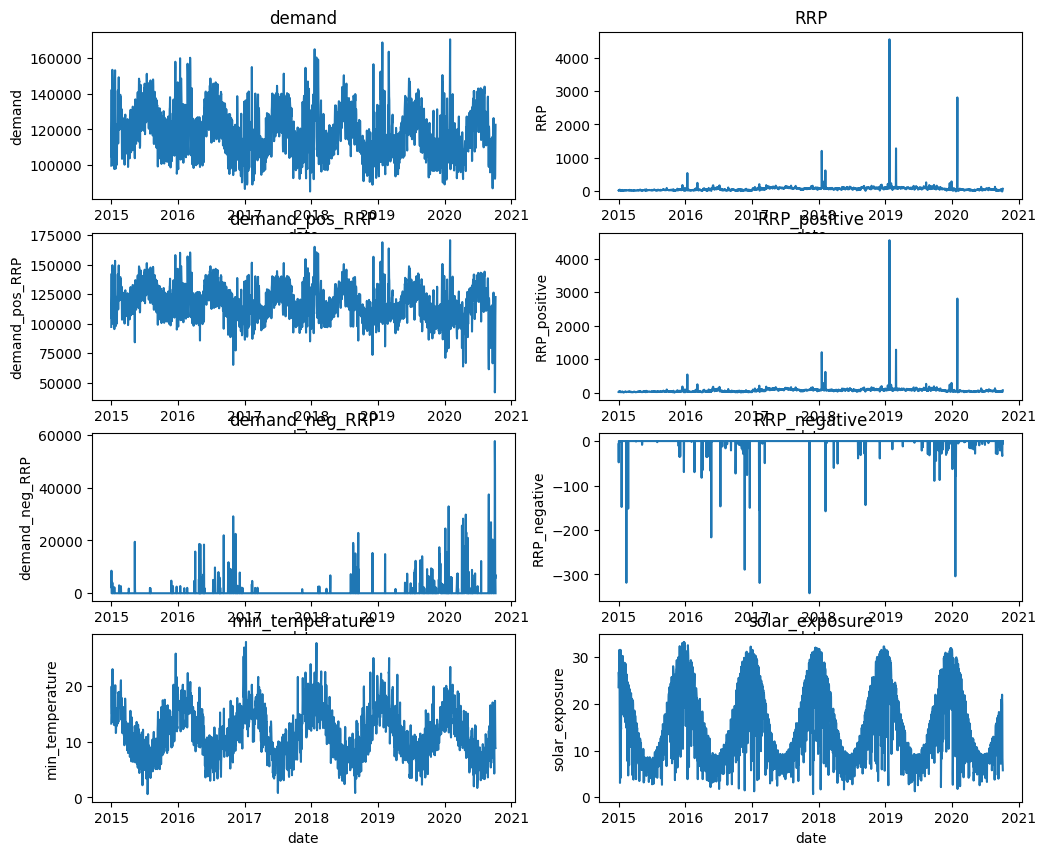

In [9]:
plt.figure(figsize = (12, 10))
for i, col_name in enumerate(col_list):
    plt.subplot(4,2,i+1)
    sns.lineplot(x=elec['date'], y=elec[col_name])
    plt.title(col_name)    

In [10]:
# demand neg_RRP와 demand pos_RRP가 무슨 의미인지 파악 필요
## 1. neg_RRP와 pos_RRP의 합은 demand인가? 대체로 비슷하나 반드시 일치하지는 않음.
sum(elec_data2['demand_neg_RRP'] + elec_data2['demand_pos_RRP'] != elec_data2['demand'])

101

In [11]:
elec_data2[elec_data2['demand_neg_RRP'] + elec_data2['demand_pos_RRP'] != elec_data2['demand']]

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
96,2015-04-07,120235.505,21.359460,118471.680,21.694138,1763.825,-1.120000,0.020833,12.4,17.3,3.9,0.0,N,N
129,2015-05-10,103811.280,13.279841,84331.030,18.306342,19480.250,-8.480147,0.229167,12.8,16.6,5.9,8.6,Y,N
130,2015-05-11,123740.245,28.475489,121962.520,28.931652,1777.725,-2.820000,0.020833,12.4,15.9,7.9,2.6,Y,N
212,2015-08-01,125032.570,29.880140,123063.545,30.397744,1969.025,-2.470000,0.020833,6.5,11.4,4.2,0.2,Y,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,2020-10-01,106641.790,34.654671,95349.610,41.651658,11292.180,-24.426925,0.125000,9.4,19.5,21.2,1.8,N,N
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N


<Axes: >

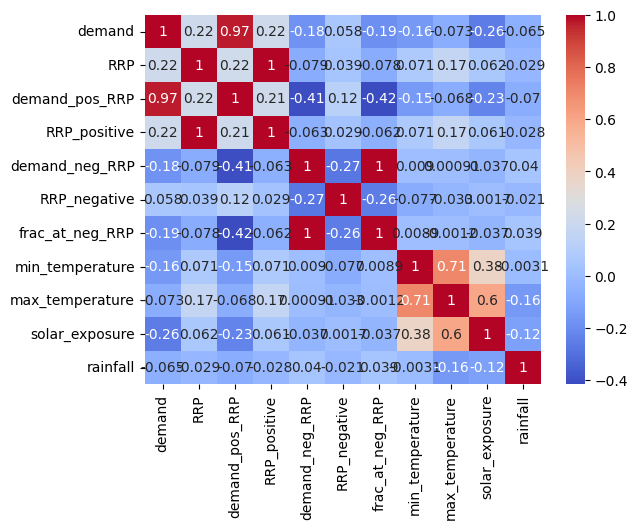

In [12]:
# 변수 간 correlation 확인
# plt.figure(figsize=(10, 10))
corr = elec_data2[[col for col in elec_data2.columns if elec_data2[col].dtypes == 'float64']].corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm')

## 상관관계 확인 결과
- 기온이 낮아지면 전력 수요가 증가. 즉, 기온과 전력 수요 간 correlation이 강함.
- negative 수요는 눈으로는 그렇다할 패턴을 찾기가 어려움.
- RRP가 매우 튀는 날이 있었지만, 수요가 크게 증가하지는 않음. seasonality가 강함.

## Seasonal Decompose

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [14]:
elec_i = elec.set_index('date')

In [15]:
elec_i.head(10)

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N
2015-01-06,130672.485,31.282311,130672.485,31.282311,0.000,0.000000,0.000000,17.7,26.0,31.6,0.0,N,N
2015-01-07,153514.820,48.312309,149498.715,49.639712,4016.105,-1.100000,0.020833,18.9,37.4,20.7,0.0,N,N
2015-01-08,142015.655,49.117280,142015.655,49.117280,0.000,0.000000,0.000000,23.1,28.2,13.5,19.4,N,N
2015-01-09,121801.155,34.490675,121801.155,34.490675,0.000,0.000000,0.000000,16.5,18.0,3.1,1.2,N,N


In [16]:
demand_decompose = seasonal_decompose(elec_i['demand'], model='additive', period = 365)

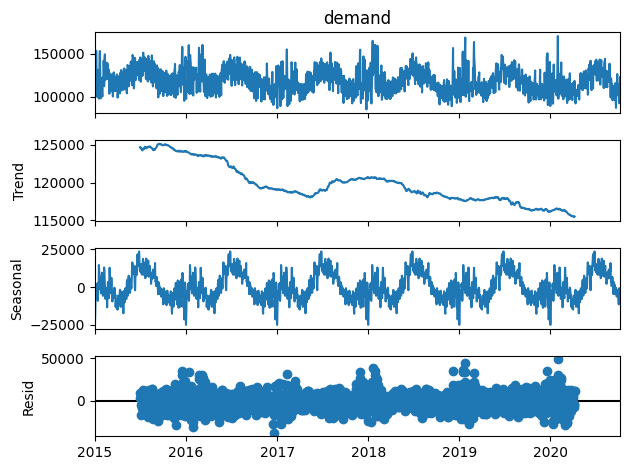

In [17]:
demand_decompose.plot()
plt.show()

In [18]:
demand_neg_decompose = seasonal_decompose(elec_i['demand_neg_RRP'], model='additive', period = 365)

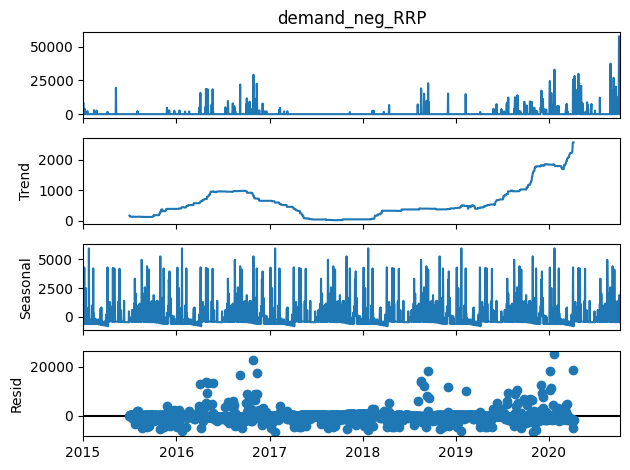

In [19]:
demand_neg_decompose.plot()
plt.show()

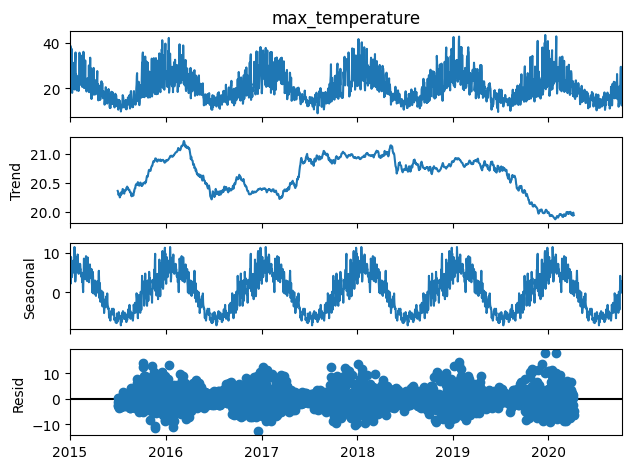

In [20]:
temp_decompose = seasonal_decompose(elec_i['max_temperature'], model='additive', period = 365)
temp_decompose.plot()
plt.show()

## holiday / school day 변수 확인

In [21]:
elec['year'] = elec['date'].dt.year

In [22]:
elec['month'] = elec['date'].dt.month

In [23]:
elec.groupby(['month', 'holiday'])['demand'].count()

month  holiday
1      N          171
       Y           15
2      N          170
3      N          174
       Y           12
4      N          157
       Y           23
5      N          186
6      N          174
       Y            6
7      N          186
8      N          186
9      N          176
       Y            4
10     N          160
       Y            1
11     N          145
       Y            5
12     N          144
       Y           11
Name: demand, dtype: int64

In [24]:
elec.groupby(['month', 'school_day'])['demand'].count().reset_index()

,month,school_day,demand
0,1,N,174
1,1,Y,12
2,2,Y,170
3,3,N,25
4,3,Y,161
5,4,N,107
6,4,Y,73
7,5,N,26
8,5,Y,160
9,6,N,23


<Axes: xlabel='month', ylabel='demand'>

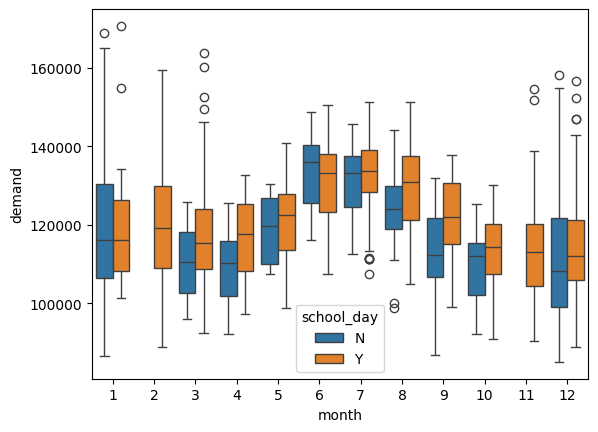

In [25]:
sns.boxplot(data = elec, x='month', y='demand', hue = 'school_day')

In [26]:
elec['is_holiday'] = pd.get_dummies(elec['holiday'], dtype = 'int32')['Y']
elec['is_school_day'] = pd.get_dummies(elec['school_day'], dtype = 'int32')['Y']

In [27]:
elec.head(5)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year,month,is_holiday,is_school_day
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y,2015,1,1,0
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N,2015,1,0,0
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N,2015,1,0,0
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N,2015,1,0,0
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N,2015,1,0,0


# TRAIN / TEST SPLIT

In [28]:
VALID_NUM = 100
train = elec[:len(elec)-VALID_NUM]
test = elec[len(elec)-VALID_NUM:]

In [40]:
len(train)

2006

In [29]:
train.tail(10)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year,month,is_holiday,is_school_day
1996,2020-06-19,120149.435,30.518707,120149.435,30.518707,0.0,0.0,0.0,6.4,17.8,8.6,0.0,Y,N,2020,6,0,1
1997,2020-06-20,109644.695,34.059332,109644.695,34.059332,0.0,0.0,0.0,12.8,16.9,8.5,1.4,Y,N,2020,6,0,1
1998,2020-06-21,121528.375,36.994379,121528.375,36.994379,0.0,0.0,0.0,6.9,12.0,4.9,0.0,Y,N,2020,6,0,1
1999,2020-06-22,136373.435,45.896190,136373.435,45.896190,0.0,0.0,0.0,8.1,13.0,5.5,0.0,Y,N,2020,6,0,1
2000,2020-06-23,131904.745,48.986743,131904.745,48.986743,0.0,0.0,0.0,9.0,14.4,8.4,2.2,Y,N,2020,6,0,1
2001,2020-06-24,133100.905,56.721436,133100.905,56.721436,0.0,0.0,0.0,10.1,14.9,8.0,0.4,Y,N,2020,6,0,1
2002,2020-06-25,131466.240,39.910040,131466.240,39.910040,0.0,0.0,0.0,10.2,15.9,5.0,0.0,Y,N,2020,6,0,1
2003,2020-06-26,136872.560,55.536961,136872.560,55.536961,0.0,0.0,0.0,7.9,13.8,8.8,1.2,N,N,2020,6,0,0
2004,2020-06-27,126938.540,48.303283,126938.540,48.303283,0.0,0.0,0.0,6.2,13.1,7.9,0.0,N,N,2020,6,0,0
2005,2020-06-28,125830.750,49.198760,125830.750,49.198760,0.0,0.0,0.0,1.7,12.5,9.3,0.2,N,N,2020,6,0,0


In [30]:
test.head(10)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year,month,is_holiday,is_school_day
2006,2020-06-29,141431.990,42.724552,141431.990,42.724552,0.00,0.00,0.000000,2.2,15.4,9.3,0.0,N,N,2020,6,0,0
2007,2020-06-30,137644.865,32.463375,134965.855,33.278861,2679.01,-8.62,0.020833,3.0,15.2,7.7,0.0,N,N,2020,6,0,0
2008,2020-07-01,126614.720,33.158432,126614.720,33.158432,0.00,0.00,0.000000,9.8,17.4,9.1,0.0,N,N,2020,7,0,0
2009,2020-07-02,131372.710,37.366426,131372.710,37.366426,0.00,0.00,0.000000,10.2,15.1,7.3,1.2,N,N,2020,7,0,0
2010,2020-07-03,143010.270,43.512020,143010.270,43.512020,0.00,0.00,0.000000,7.7,10.3,4.1,0.0,N,N,2020,7,0,0
2011,2020-07-04,125400.270,50.026101,125400.270,50.026101,0.00,0.00,0.000000,6.5,14.5,5.7,7.8,N,N,2020,7,0,0
2012,2020-07-05,118507.760,50.787713,118507.760,50.787713,0.00,0.00,0.000000,8.9,12.5,6.5,4.6,N,N,2020,7,0,0
2013,2020-07-06,136255.335,75.960623,136255.335,75.960623,0.00,0.00,0.000000,8.1,13.1,5.8,1.0,N,N,2020,7,0,0
2014,2020-07-07,140264.520,88.336243,140264.520,88.336243,0.00,0.00,0.000000,8.9,11.8,4.8,1.4,N,N,2020,7,0,0
2015,2020-07-08,138627.110,80.388197,138627.110,80.388197,0.00,0.00,0.000000,4.9,15.7,9.4,0.0,N,N,2020,7,0,0


<Axes: >

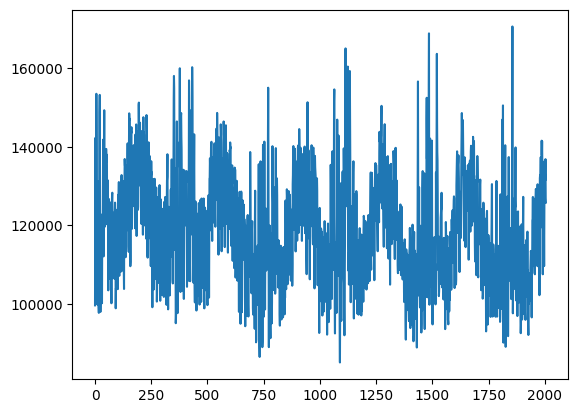

In [31]:
train['demand'].plot()

<Axes: >

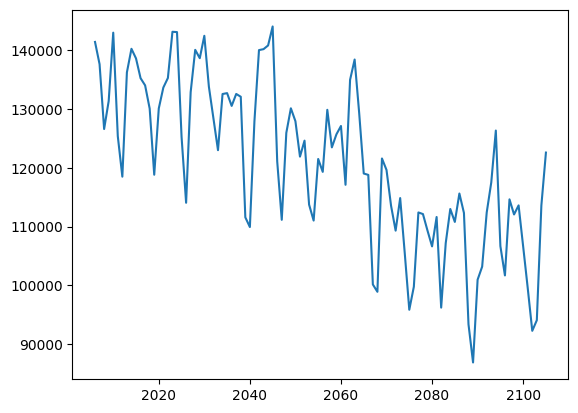

In [32]:
test['demand'].plot()

# ARIMA

## 정상성 검정

In [33]:
adf_result = adfuller(train['demand'])

In [34]:
adf_result

(-3.8625410319218307,
 0.0023284888266217113,
 26,
 1979,
 {'1%': -3.4336586419118653,
  '5%': -2.8630015713430743,
  '10%': -2.567548079537008},
 41017.88179796392)

* p-value(2번째 레코드)가 0.05보다 작음. 즉, 귀무가설을 기각하여 정상성을 만족하는 것처럼 보임

## AutoARIMA로 최적모델 확인

In [35]:
auto = auto_arima(train['demand'], trace = True, seasonal=True )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=42337.549, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=43035.795, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43024.584, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43000.007, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43033.798, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=42399.887, Time=1.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=42345.278, Time=0.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=42333.814, Time=3.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=42347.248, Time=1.61 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=42143.556, Time=7.91 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=42269.692, Time=1.63 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=42120.219, Time=8.83 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=42142.849, Time=1.58 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.91 sec
 ARIMA(4,1,3)(0,0,0)[0] i

* ARIMA(4, 1, 5)를 추천받아서 그대로 사용.

## ARIMA (4,1,5) 적용

In [36]:
arima_4_1_5 = ARIMA(train['demand'], order = (4, 1, 5))

In [37]:
arima_4_1_5_result = arima_4_1_5.fit()
arima_4_1_5_result.summary()

C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 demand   No. Observations:                 2006
Model:                 ARIMA(4, 1, 5)   Log Likelihood              -20925.040
Date:                Sat, 13 Apr 2024   AIC                          41870.080
Time:                        10:52:58   BIC                          41926.114
Sample:                             0   HQIC                         41890.652
                               - 2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6434      0.022     29.607      0.000       0.601       0.686
ar.L2         -1.2923      0.014    -95.332      0.000      -1.319      -1.266
ar.L3          0.7339      0.020     37.331      0.000       0.695       0.772
ar.L4         -0.7774      0.016    -49.771      0.000      -0.808      -0.747
ma.L1         -0.8009      0.024    -33.053      0.000      -0.848      -0.753
ma.L2          1.0578      0.027     39.077      0.000       1.005       1.111
ma.L3         -1.1320      0.024    -47.742      0.000      -1.179      -1.086
ma.L4          0.5273      0.029     18.313      0.000       0.471       0.584
ma.L5         -0.2185      0.024     -8.961      0.000      -0.266      -0.171
sigma2      7.846e+07   3.52e-10   2.23e+17      0.000    7.85e+07    7.85e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              1056.34
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.46
Prob(H) (two-sided):                  0.12   Kurtosis:                         6.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.59e+32. Standard errors may be unstable.
"""

In [45]:
arima_4_1_5_predict = arima_4_1_5_result.predict(start = 1, end = len(elec), typ='levels').rename("ARIMA(4,1,5)")

C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

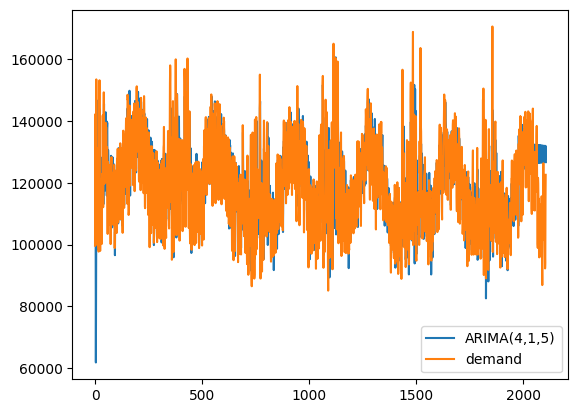

In [46]:
arima_4_1_5_predict.plot(legend = True)
elec['demand'].plot(legend = True)

* 대충 봐도 안 맞아보임..

## 외생변수를 고려한 ARIMA 모형 적용

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2006 non-null   datetime64[ns]
 1   demand           2006 non-null   float64       
 2   RRP              2006 non-null   float64       
 3   demand_pos_RRP   2006 non-null   float64       
 4   RRP_positive     2006 non-null   float64       
 5   demand_neg_RRP   2006 non-null   float64       
 6   RRP_negative     2006 non-null   float64       
 7   frac_at_neg_RRP  2006 non-null   float64       
 8   min_temperature  2006 non-null   float64       
 9   max_temperature  2006 non-null   float64       
 10  solar_exposure   2005 non-null   float64       
 11  rainfall         2003 non-null   float64       
 12  school_day       2006 non-null   object        
 13  holiday          2006 non-null   object        
 14  year             2006 non-null   int32  

* 일부 데이터에 NULL값이 있음. 외생변수를 고려하려면 null이 없어야 함. 즉, 결측치 처리를 해줘야 함.
* 일단 무지성으로 0으로 채워봄

In [49]:
train_impute = train.fillna(0)

In [50]:
exog_var = ['year', 'month', 'is_holiday', 'is_school_day', 'max_temperature', 'solar_exposure']

In [51]:
arima_4_1_5_exo = ARIMA(train_impute['demand'], order = (4, 1, 5), 
                        exog = train_impute[exog_var])

In [52]:
arima_4_1_5_exo_result = arima_4_1_5_exo.fit()

In [53]:
arima_4_1_5_exo_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 demand   No. Observations:                 2006
Model:                 ARIMA(4, 1, 5)   Log Likelihood              -21429.811
Date:                Sat, 13 Apr 2024   AIC                          42891.622
Time:                        10:59:47   BIC                          42981.276
Sample:                             0   HQIC                         42924.537
                               - 2006                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
year            -9907.4938     25.936   -381.992      0.000   -9958.328   -9856.659
month            -948.6462    378.341     -2.507      0.012   -1690.181    -207.111
is_holiday      -9128.4577    726.512    -12.565      0.000   -1.06e+04   -7704.521
is_school_day    1437.3532   1438.260      0.999      0.318   -1381.584    4256.290
max_temperature   787.5720     25.201     31.251      0.000     738.178     836.966
solar_exposure   -193.9089     23.636     -8.204      0.000    -240.235    -147.583
ar.L1               0.4627      3.461      0.134      0.894      -6.320       7.246
ar.L2              -0.5549      2.835     -0.196      0.845      -6.111       5.001
ar.L3               0.3796      2.404      0.158      0.875      -4.333       5.092
ar.L4              -0.1640      2.183     -0.075      0.940      -4.442       4.114
ma.L1              -0.4621      3.461     -0.134      0.894      -7.245       6.321
ma.L2               0.5548      2.835      0.196      0.845      -5.002       6.111
ma.L3              -0.3802      2.406     -0.158      0.874      -5.096       4.336
ma.L4               0.1647      2.185      0.075      0.940      -4.117       4.447
ma.L5              -0.0003      0.001     -0.231      0.817      -0.003       0.002
sigma2            6.89e+07      0.020   3.46e+09      0.000    6.89e+07    6.89e+07
===================================================================================
Ljung-Box (L1) (Q):                   6.73   Jarque-Bera (JB):                31.02
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.18
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+25. Standard errors may be unstable.
"""

In [63]:
arima_4_1_5_exo_predict = arima_4_1_5_exo_result.predict(start = 1, end = len(elec), 
                                                         exog = test[exog_var],
                                                         typ='levels').rename("ARIMA(4,1,5)")

ValueError: Provided exogenous values are not of the appropriate shape. Required (101, 6), got (100, 6).

* 에러가 떨어짐, 아마도 차분을 한 번 했기 때문에 데이터가 하나 더 필요한 것으로 추정.
* train data의 마지막 데이터를 붙여줘 봄.

In [64]:
pd.DataFrame(train_impute[exog_var].iloc[-1,:]).T

,year,month,is_holiday,is_school_day,max_temperature,solar_exposure
2005,2020.0,6.0,0.0,0.0,12.5,9.3


In [65]:
pd.concat([pd.DataFrame(train_impute[exog_var].iloc[-1,:]).T,test[exog_var]], axis = 0)

,year,month,is_holiday,is_school_day,max_temperature,solar_exposure
2005,2020.0,6.0,0.0,0.0,12.5,9.3
2006,2020.0,6.0,0.0,0.0,15.4,9.3
2007,2020.0,6.0,0.0,0.0,15.2,7.7
2008,2020.0,7.0,0.0,0.0,17.4,9.1
2009,2020.0,7.0,0.0,0.0,15.1,7.3
...,...,...,...,...,...,...
2101,2020.0,10.0,0.0,0.0,26.0,22.0
2102,2020.0,10.0,0.0,0.0,29.4,19.8
2103,2020.0,10.0,0.0,0.0,29.5,8.4
2104,2020.0,10.0,0.0,0.0,12.7,7.3


In [66]:
test[exog_var]

,year,month,is_holiday,is_school_day,max_temperature,solar_exposure
2006,2020,6,0,0,15.4,9.3
2007,2020,6,0,0,15.2,7.7
2008,2020,7,0,0,17.4,9.1
2009,2020,7,0,0,15.1,7.3
2010,2020,7,0,0,10.3,4.1
...,...,...,...,...,...,...
2101,2020,10,0,0,26.0,22.0
2102,2020,10,0,0,29.4,19.8
2103,2020,10,0,0,29.5,8.4
2104,2020,10,0,0,12.7,7.3


In [71]:
pd.concat([pd.DataFrame(train_impute[exog_var].iloc[-1,:]).T,test[exog_var].iloc[:-1, :]])

,year,month,is_holiday,is_school_day,max_temperature,solar_exposure
2005,2020.0,6.0,0.0,0.0,12.5,9.3
2006,2020.0,6.0,0.0,0.0,15.4,9.3
2007,2020.0,6.0,0.0,0.0,15.2,7.7
2008,2020.0,7.0,0.0,0.0,17.4,9.1
2009,2020.0,7.0,0.0,0.0,15.1,7.3
...,...,...,...,...,...,...
2100,2020.0,10.0,0.0,0.0,19.5,21.2
2101,2020.0,10.0,0.0,0.0,26.0,22.0
2102,2020.0,10.0,0.0,0.0,29.4,19.8
2103,2020.0,10.0,0.0,0.0,29.5,8.4


In [73]:
arima_4_1_5_exo_predict = arima_4_1_5_exo_result.predict(start = 1, end = len(elec), 
                                                         exog = pd.concat(
                                                             [pd.DataFrame(train_impute[exog_var].iloc[-1,:]).T,
                                                              test[exog_var]], axis = 0),
                                                         typ='levels').rename("ARIMA(4,1,5)_exog")

C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [74]:
arima_4_1_5_exo_predict

1       130159.942491
2       133839.359960
3       111544.936566
4       111083.025547
5       128059.094004
            ...      
2102    130209.100609
2103    133313.444828
2104    135602.763137
2105    122584.853754
2106    122796.959861
Name: ARIMA(4,1,5)_exog, Length: 2106, dtype: float64

<Axes: >

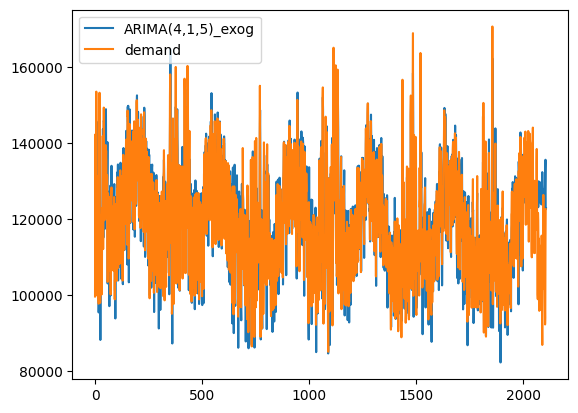

In [75]:
arima_4_1_5_exo_predict.plot(legend = True)
elec['demand'].plot(legend = True)

* 그림이 아까보다는 나아보이지만 여전히 차이가 많이 남.

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [91]:
# mse_arima_exo = mean_squared_error(arima_4_1_5_exo_predict, elec['demand'])
# mae_arima_exo = mean_absolute_error(arima_4_1_5_exo_predict, elec['demand'])
# print(f"MAE of ARIMA(4,1,5) with exog var : {mae_arima_exo}")
# print(f"MSE of ARIMA(4,1,5) with exog var : {mse_arima_exo}")

MAE of ARIMA(4,1,5) with exog var : 3483.419889691914
MSE of ARIMA(4,1,5) with exog var : 31222187.073232364


In [96]:
mse_arima_exo_test = mean_squared_error(arima_4_1_5_exo_predict[-100:], test['demand'])
mae_arima_exo_test = mean_absolute_error(arima_4_1_5_exo_predict[-100:], test['demand'])
print(f"MAE of ARIMA(4,1,5) with exog var : {mae_arima_exo_test}")
print(f"MSE of ARIMA(4,1,5) with exog var : {mse_arima_exo_test}")

MAE of ARIMA(4,1,5) with exog var : 12557.963812052178
MSE of ARIMA(4,1,5) with exog var : 250780317.31786388


In [93]:
# mse_arima = mean_squared_error(arima_4_1_5_predict, elec['demand'])
# mae_arima = mean_absolute_error(arima_4_1_5_predict, elec['demand'])
# print(f"MAE of ARIMA(4,1,5) : {mae_arima}")
# print(f"MSE of ARIMA(4,1,5) : {mse_arima}")


MAE of ARIMA(4,1,5) : 6154.148833308603
MSE of ARIMA(4,1,5) : 67518133.1873409


In [98]:
mse_arima_test = mean_squared_error(arima_4_1_5_predict[-100:], test['demand'])
mae_arima_test = mean_absolute_error(arima_4_1_5_predict[-100:], test['demand'])
print(f"MAE of ARIMA(4,1,5) with exog var : {mae_arima_test}")
print(f"MSE of ARIMA(4,1,5) with exog var : {mse_arima_test}")

MAE of ARIMA(4,1,5) with exog var : 13394.91936956929
MSE of ARIMA(4,1,5) with exog var : 280789179.10762656


* 외생변수를 고려한 쪽의 모형 성능이 r그나마 더 좋음.

# Prophet

In [81]:
# holiday 어거지로 넣기
holiday = []
for row in elec.itertuples():
    if row.holiday == 'Y':
        holiday.append(row.date)

In [82]:
holidays = pd.DataFrame({'ds' : holiday, 'holiday': 'HOLIDAYS'})

In [83]:
holidays

,ds,holiday
0,2015-01-01,HOLIDAYS
1,2015-01-26,HOLIDAYS
2,2015-03-09,HOLIDAYS
3,2015-04-03,HOLIDAYS
4,2015-04-04,HOLIDAYS
...,...,...
72,2020-04-11,HOLIDAYS
73,2020-04-12,HOLIDAYS
74,2020-04-13,HOLIDAYS
75,2020-04-25,HOLIDAYS


In [84]:
prophet_model = Prophet(holidays = holidays )

In [85]:
prophet_train = train[['date', 'demand']]
prophet_train.columns = ['ds', 'y']
prophet_train.head(10)

,ds,y
0,2015-01-01,99635.030
1,2015-01-02,129606.010
2,2015-01-03,142300.540
3,2015-01-04,104330.715
4,2015-01-05,118132.200
5,2015-01-06,130672.485
6,2015-01-07,153514.820
7,2015-01-08,142015.655
8,2015-01-09,121801.155
9,2015-01-10,103043.660


In [86]:
prophet_result = prophet_model.fit(prophet_train)

11:10:36 - cmdstanpy - INFO - Chain [1] start processing
11:10:37 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
future = prophet_result.make_future_dataframe(periods=100)
forecast = prophet_result.predict(future)

C:\Users\sinra\anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\sinra\anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


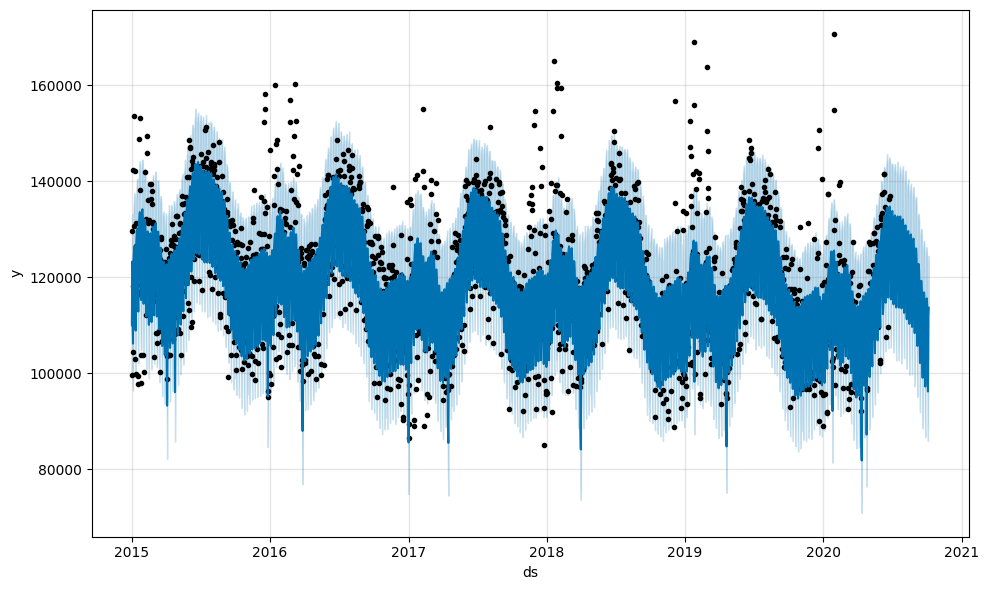

In [88]:
prophet_result.plot(forecast)
plt.show()

<Axes: >

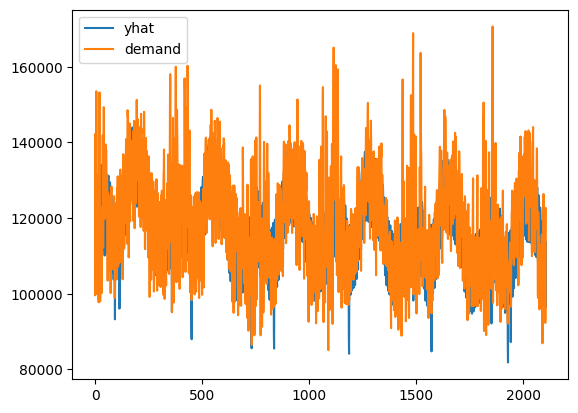

In [99]:
forecast['yhat'].plot(legend = True)
elec['demand'].plot(legend = True)

In [94]:
mse_prophet = mean_squared_error(forecast['yhat'], elec['demand'])
mae_prophet = mean_absolute_error(forecast['yhat'], elec['demand'])
print(f"MAE of ARIMA(4,1,5) : {mae_prophet}")
print(f"MSE of ARIMA(4,1,5) : {mse_prophet}")

MAE of ARIMA(4,1,5) : 5945.658498440892
MSE of ARIMA(4,1,5) : 68006449.87309244


In [102]:
forecast['yhat'][-100:]

2006    131109.256602
2007    132865.271677
2008    133530.963319
2009    133774.453154
2010    132051.686467
            ...      
2101    113880.074859
2102    100398.277445
2103     96189.014687
2104    111890.149255
2105    113641.261068
Name: yhat, Length: 100, dtype: float64

In [103]:
mse_prophet_test = mean_squared_error(forecast['yhat'][-100:], test['demand'])
mae_prophet_test = mean_absolute_error(forecast['yhat'][-100:], test['demand'])
print(f"MAE of ARIMA(4,1,5) : {mae_prophet_test}")
print(f"MSE of ARIMA(4,1,5) : {mse_prophet_test}")

MAE of ARIMA(4,1,5) : 6625.454186348914
MSE of ARIMA(4,1,5) : 63789191.643742226


* 결론적으로 Prophet을 돌렸을 때 성능이 제일 나았음. HOLIDAY 효과가 주요한 변수였던 것일까..